## Zaimportowane biblioteki

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from collections import Counter
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.special import erfinv
from scipy.linalg import cholesky

## Zadanie 1

Generator MRG32k3a został zaimplementowany według algorytmu podanego w treści zadania. Na koniec każdej iteracji pętli usuwamy te wartości $X_k$ oraz $Y_k$, których nie będziemy już wiecęj używać aby nie przechowywać zbędnych wartości w tablicach.


In [217]:
def MRG32k3a(n):
    results = np.empty(n)                                   #funkcja z zaimplementowanym algorytmem
    m1 = 2**32 - 209                                        #przyjmuje wielkość generowanej próbki i zwraca tablice z wygenerowanymi wartościami
    m2 = 2**32 - 22853
    xs = np.array([321678674, 749714321, 37298312])
    ys = np.array([564813133, 484132546, 54642463])
    for i in range(n):
        x_k = (1403580*xs[1] - 810728*xs[2])%m1
        y_k = (527612*ys[0] - 1370589*ys[2])%m2
        if x_k <= y_k:
            results[i] = (x_k-y_k+m1)/(m1+1)
        else:
            results[i] = (x_k-y_k)/(m1+1)  
        xs = np.delete(xs, 2)
        ys = np.delete(ys, 2)
        xs = np.insert(xs, 0, x_k)
        ys = np.insert(ys, 0, y_k)
    return results
y = MRG32k3a(100000)

C:\Users\marci\AppData\Local\Temp\ipykernel_11208\692286633.py:8: RuntimeWarning: overflow encountered in scalar multiply
  x_k = (1403580*xs[1] - 810728*xs[2])%m1
C:\Users\marci\AppData\Local\Temp\ipykernel_11208\692286633.py:9: RuntimeWarning: overflow encountered in scalar multiply
  y_k = (527612*ys[0] - 1370589*ys[2])%m2
C:\Users\marci\AppData\Local\Temp\ipykernel_11208\692286633.py:8: RuntimeWarning: overflow encountered in scalar subtract
  x_k = (1403580*xs[1] - 810728*xs[2])%m1
C:\Users\marci\AppData\Local\Temp\ipykernel_11208\692286633.py:9: RuntimeWarning: overflow encountered in scalar subtract
  y_k = (527612*ys[0] - 1370589*ys[2])%m2


Na poniższym wykresie możemy zobaczyć co dwudziestą piątą z 100000 wygenerowanych wartości za pomocą generatora MRG32k3a

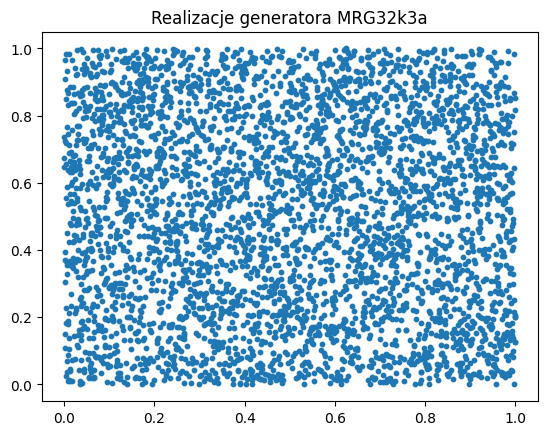

In [218]:
x = np.linspace(0,1,100000)
plt.scatter(x[::25], y[::25], s=10)
plt.title('Realizacje generatora MRG32k3a')
plt.show()

Teraz porównamy histogram realizacji generatora, który jest estymatorem gęstości rozkładu. Na wykresie widać, że histogram w dużym stopniu pokrywa się z gęstością teoretyczną rozkładu $U(0,1)$. 

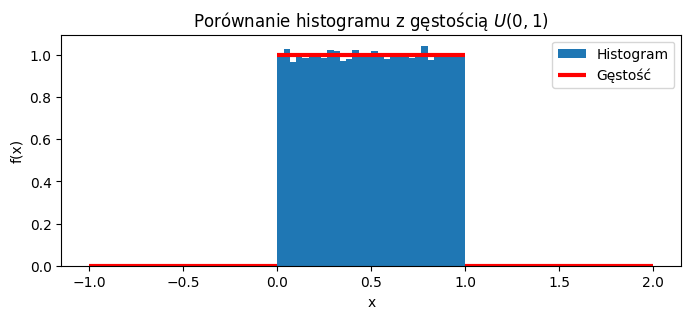

In [219]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
ax.hist(y, bins = 30, density=True, label='Histogram')
ax.hlines(y=1, xmin=0, xmax=1, colors='r', linewidth = 3, label='Gęstość')
ax.hlines(y=0, xmin=-1, xmax=0, colors='r', linewidth = 3)
ax.hlines(y=0, xmin=1, xmax=2, colors='r', linewidth = 3)
ax.set_title(r'Porównanie histogramu z gęstością $U(0,1)$')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend()
plt.show()

In [62]:
stats.kstest(y, 'uniform')


KstestResult(statistic=0.00208345144705796, pvalue=0.7773564150806664, statistic_location=0.401463451447058, statistic_sign=-1)

Test statystyczny Kołmogorowa-Smirnowa zwraca wartość pvalue na poziomie 0.77 co wskazuje na to, że próbka otrzymana z generatora dobrze przybliża rozkład $U(0,1)$

In [63]:
start_acc = time.perf_counter()
MRG32k3a(10000)
end_mrg = time.perf_counter()
start_np = time.perf_counter()
np.random.rand(10000)
end_rand = time.perf_counter()
print(f"Wydajność naszego generatora MRG32k3a: {end_mrg-start_acc}\nWydajność funkcji wbudowanej rand: {end_rand-start_np}")

C:\Users\marci\AppData\Local\Temp\ipykernel_11208\502151198.py:8: RuntimeWarning: overflow encountered in scalar multiply
  x_k = (1403580*xs[1] - 810728*xs[2])%m1
C:\Users\marci\AppData\Local\Temp\ipykernel_11208\502151198.py:9: RuntimeWarning: overflow encountered in scalar multiply
  y_k = (527612*ys[0] - 1370589*ys[2])%m2
C:\Users\marci\AppData\Local\Temp\ipykernel_11208\502151198.py:8: RuntimeWarning: overflow encountered in scalar subtract
  x_k = (1403580*xs[1] - 810728*xs[2])%m1
C:\Users\marci\AppData\Local\Temp\ipykernel_11208\502151198.py:9: RuntimeWarning: overflow encountered in scalar subtract
  y_k = (527612*ys[0] - 1370589*ys[2])%m2


Wydajność naszego generatora MRG32k3a: 1.0077218000078574
Wydajność funkcji wbudowanej rand: 0.0002422000397928059


## Zadanie 2

W zadaniu drugim użyliśmy metody akceptacji odrzucenia dla rozkładów dyskretnych aby wygenerować rozkład Poissona za pomocą rozkładu wykładniczego.


In [4]:
def pois(x, lam=2):
    return np.exp(-lam)*(lam**x)/(np.math.factorial(x)) #funkcja masy prawdopodobieństwa rozkładu Poissona

def geom(x, p=1/2):         #funkcja masy prawdopodobieństwa rozkładu Geometrycznego
    return (1-p)**x*p

c = max([pois(x)/geom(x) for x in range(1,10)])  #wyliczamy stałą c potrzebną do metody akceptacji odrzucenia


def accept_reject(n=10000):           #zaimplementowanie algorytmu akceptacji odrzucenia dla rozkładów dyskretnych
    results = np.empty(n)             #przyjmuje wielkość generowanej próbki i zwraca tablice z wygenerowanymi wartościami
    for i in range(n):
        y = np.random.geometric(1/2) - 1
        u = np.random.uniform(0,1)
        while u*c*geom(y) > pois(y):
            y = np.random.geometric(1/2) - 1
            u = np.random.uniform(0,1)
        results[i] = y
    return results

y = accept_reject()
numpy = np.random.poisson(lam = 2, size = 10000) 
dictionary = {key: value/10000 for (key, value) in Counter(accept_reject()).items()} #unormowanie wartości wygenerowanych za pomocą metody akceptacji odrzucenia
dictionary2 = {key: value/10000 for (key, value) in Counter(numpy).items()} #oraz wbudowanej funkcji z biblioteki numpy

Na poniższych wykresach możemy zobaczyć histogramy odpowiadające wartościom funkcji masy prawdopodobieństwa rozkładu Poissona wygenerowane za pomocą metody akceptacji odrzucenia oraz funkcji wbudowanej biblioteki numpy. Dzięki nim widać poprawność zaimplementowanego algorytmu.

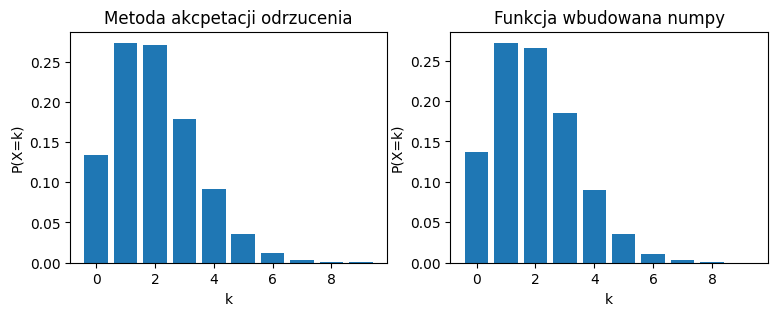

In [5]:
fig, ax = plt.subplots(1,2, figsize=(9,3))
ax[0].bar(dictionary.keys(), dictionary.values())
ax[0].set_title('Metoda akcpetacji odrzucenia')
ax[0].set_xlabel('k')
ax[0].set_ylabel('P(X=k)')
ax[1].bar(dictionary2.keys(), dictionary2.values())
ax[1].set_title('Funkcja wbudowana numpy')
ax[1].set_xlabel('k')
ax[1].set_ylabel('P(X=k)')
plt.show()

In [69]:
start_acc = time.perf_counter()
accept_reject()
end_acc = time.perf_counter()
start_np = time.perf_counter()
numpy = np.random.poisson(lam = 2, size = 10000) 
end_np = time.perf_counter()
print(f"Wydajność metody akceptacji odrzucenia: {end_acc-start_acc}\nWydajność funkcji wbudowanej numpy: {end_np-start_np}")

Wydajność metody akceptacji odrzucenia: 0.35537880001356825
Wydajność funkcji wbudowanej numpy: 0.0010607999865897


## Zadanie 3

In [74]:
def exp(x):                                     #gęstość rozkładu wykładniczego Exp(1)
    return np.exp(-x)

def norm(x):                                     #gęstość rozkładu normalnego N(0,1)
    return 1/(np.sqrt(2*np.pi))*np.exp((-x**2)/2)

def inverse_cdf(x):                            #funkcja odwrotna do gęstości rozkładu normalnego N(0,1)
    return np.sqrt(-2*np.log(np.sqrt(2*np.pi)*x))

def segments(num_segments=256):                #funkcja dzieląca pole pod gęstością rozkładu normalnego na odcinku [0,5]
    area = 0.5/num_segments                    #na segmenty o równych polach
    lim = 5                                    #przyjmuje ilość segmentów na które dzielimy pole i zwraca współrzędne punktów
    xs = np.empty(num_segments)                #które tworzą segmenty
    ys = np.empty(num_segments)
    xs[0] = lim
    ys[0] = norm(xs[0])
    xs[1] = lim
    ys[1] = ys[0] + (area/xs[1])
    for i in range(2, num_segments):
        xs[i] = inverse_cdf(ys[i-1])
        ys[i] = ys[i-1] + (area/xs[i])
    ys[-1] = norm(0)
    return xs, ys
xs, ys = segments()

def fallback():                                     #funkcja zwracająca wartość z ogona rozkładu normalnego 
    x1 = xs[0]                                      #według algorytmu zaproponowanego przez Marsaglie
    u1 = np.random.uniform()
    u2 = np.random.uniform()
    x = -np.log(u1)/x1
    y = -np.log(u2)
    while 2*y <= x**2:
        u1 = np.random.uniform()
        u2 = np.random.uniform()
        x = -np.log(u1)/x1
        y = -np.log(u2)
    return x + x1

In [81]:
def ziggurat(n=10000):                                  
    results = np.empty(n)                 #zaimplementowany algorytm ziggurata
    pdf_count = 0                         #przyjmuje wielkość generowanej próbki i zwraca tablice z wygenerowanymi wartościami
    for i in range(n):
        control = True
        while control:
            u1 = np.random.uniform(-1,1)
            u2 = np.random.uniform()
            idx = np.random.randint(0, len(xs))
            if idx == 0:
                control = False
                results[i] = fallback()
            x = u1*xs[idx-1]
            if abs(x) < xs[idx]:
                control = False
            else:
                y = ys[idx] + u2*(ys[idx]-ys[idx-1])
                fx = exp(x)
                pdf_count += 1
                if y < fx:
                    control = False
        results[i] = x
    return results, pdf_count    
data, pdf_count = ziggurat()
pdf_count

116

Na poniższym wykresie możemy zobaczyć histogram wygenerowanych wartości odpowiadający gęstości teoretycznej standardowego rozkładu normalnego. Wartość gęstości rozkładu wykładniczego zostaje obliczona około 100 razy przy podziale na 256 segmentów.

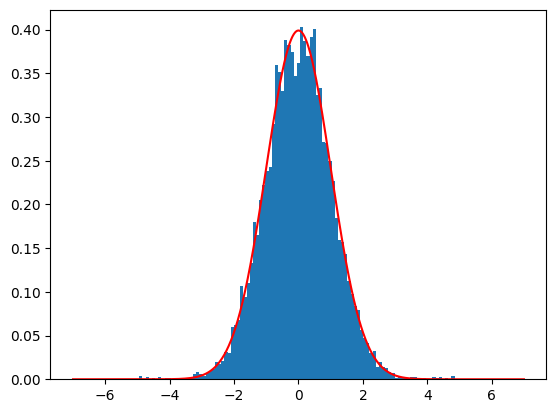

In [82]:
x = np.linspace(-7,7,1000)
plt.hist(data, bins='sqrt', density=True, label='Histogram')
plt.plot(x, stats.norm.pdf(x), c='r', label='Gęstość teoretyczna')

## Zadanie 4

Metody zaimplentowane zostały zaimplementowany w sposób przedstawiony na laboratoriach. Są to:

-metoda odwrotnej dystrybuanty,

-metoda akceptacji odrzucenia za pomocą rozkładu Cauchy'ego,

-metoda stosunku jednostajnych,

-metoda Boxa-Mullera,

-metoda Marsaglii,

-metoda Zigguratu.

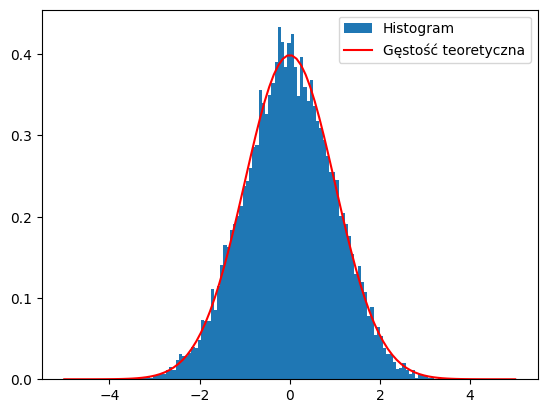

In [119]:
#Metoda odwrotnej dystrybuanty
def inverse_cdf(x, mi=0,sigma=1):
    return mi + sigma*np.sqrt(2)*erfinv(2*x-1)

x1 = np.random.uniform(0,1,10000)
x2 = np.linspace(-5, 5, 100)
plt.hist(inverse_cdf(x1), bins='sqrt', density=True, label='Histogram')
plt.plot(x2, stats.norm.pdf(x2), label='Gęstość teoretyczna', c='r')
plt.legend()
plt.show()

In [120]:
start = time.perf_counter()
data = inverse_cdf(np.random.uniform(0,1,10000))
end = time.perf_counter()
inv_cdf_time = end-start
inv_cdf_pvalue_ks = scipy.stats.kstest(data, 'norm')[1]
inv_cdf_pvalue_jb = scipy.stats.jarque_bera(data)[1]

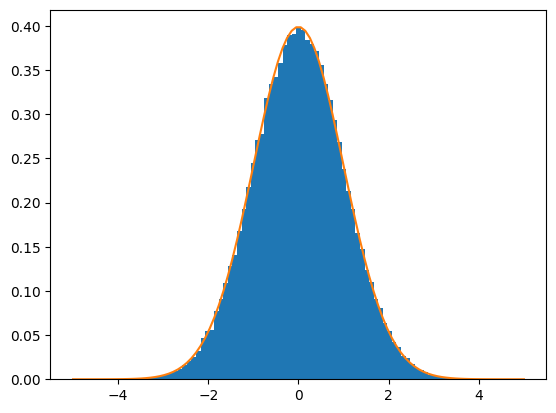

In [121]:
#metoda akceptacji odrzucenia
C = 2 * np.exp(-1/2)

def cauchy(x):
    return 1/(1+x**2)
def norm(x):
    return np.e**(-x**2/2)

def accept_reject_norm(n=100000):
    results = np.empty(n)
    for i in range(n):
        u1 = np.random.standard_cauchy()
        u2 = np.random.uniform(0, C)
        while C * u2 * cauchy(u1) > norm(u1):
            u1 = np.random.standard_cauchy()
            u2 = np.random.uniform(0, C)
        results[i] = u1
    return results

data = accept_reject_norm()
x = np.linspace(-5,5, 100)
plt.hist(data, bins=np.linspace(-5,5,100), density=True)
plt.plot(x,stats.norm.pdf(x))
plt.show()

In [122]:
start = time.perf_counter()
data = accept_reject_norm()
end = time.perf_counter()
accept_reject_time = end-start
accept_reject_pvalue_ks = scipy.stats.kstest(data, 'norm')[1]
accept_reject_pvalue_jb = scipy.stats.jarque_bera(data)[1]


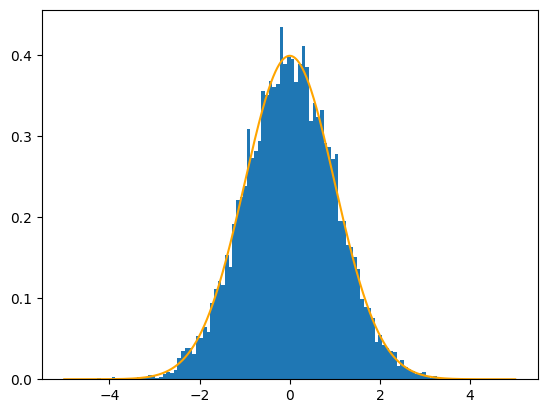

In [123]:
#metoda stosunku jednostajnych
def norm(x):
    return np.e**(-x**2/2)

def ratio_of_uni(n=10000):
    vals = np.empty(n)
    for i in range(n):
        x = np.random.uniform(0,1)
        y = np.random.uniform(-1,1)
        while x**2 > norm(y/x):
            x = np.random.uniform(0,1)
            y = np.random.uniform(-1,1)
        vals[i] = y/x
    return vals
y = ratio_of_uni()
x = np.linspace(-5,5, 1000)
plt.hist(y, bins='sqrt', density = True)
plt.plot(x, norm(x)/np.sqrt(2*np.pi), c='orange')
plt.show()

In [124]:
start = time.perf_counter()
data = ratio_of_uni()
end = time.perf_counter()
ratio_time = end-start
ratio_pvalue_ks = scipy.stats.kstest(data, 'norm')[1]
ratio_pvalue_jb = scipy.stats.jarque_bera(data)[1]


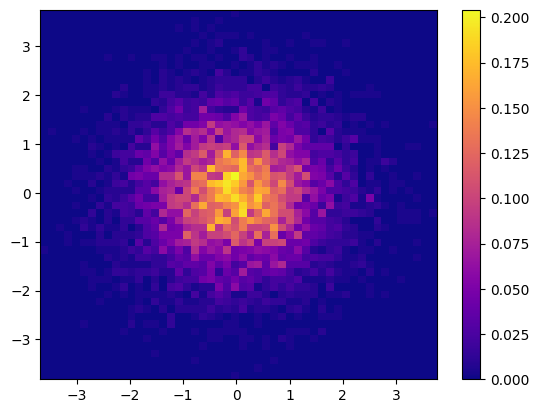

In [125]:
#Metoda boxa-mullera
def box_muller(n=10000):
    U1 = np.random.uniform(0,1, size = n)
    U2 = np.random.uniform(0,1, size = n)
    X = np.sqrt(-2*np.log(U1))*np.cos(2*np.pi*U2)
    Y = np.sqrt(-2*np.log(U1))*np.sin(2*np.pi*U2)
    return X,Y

x,y = box_muller()
plt.hist2d(x, y, bins = 50, cmap='plasma', density=True)
plt.colorbar()
plt.show()

In [126]:
start = time.perf_counter()
data = box_muller()
end = time.perf_counter()
box_muller_time = end-start
box_muller_pvalue_ks = scipy.stats.kstest(data[0], 'norm')[1]
box_muller_pvalue_jb = scipy.stats.jarque_bera(data[0])[1]

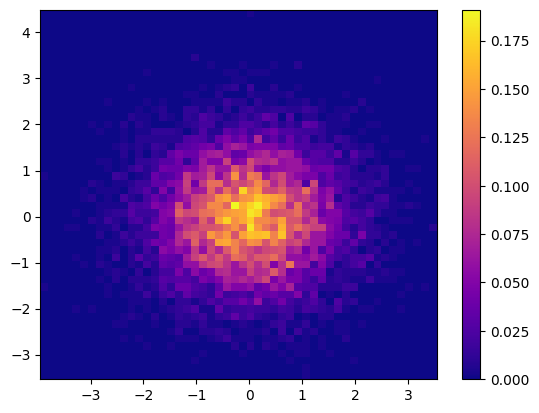

In [127]:
def marsaglia(n=10000):
    X = np.empty(n)
    Y = np.empty(n)
    for i in range(n):
        V1 = np.random.uniform(-1,1)
        V2 = np.random.uniform(-1,1)
        r_kw = V1**2 + V2**2
        while r_kw>1:
            V1 = np.random.uniform(-1,1)
            V2 = np.random.uniform(-1,1)
            r_kw = V1**2 + V2**2
        X[i] = np.sqrt((-2*np.log(r_kw))/r_kw)*V1
        Y[i] = np.sqrt((-2*np.log(r_kw))/r_kw)*V2
    return X, Y

x,y = marsaglia()
plt.hist2d(x, y, bins = 50, cmap='plasma', density=True)
plt.colorbar()
plt.show()

In [128]:
start = time.perf_counter()
data = marsaglia()
end = time.perf_counter()
marsaglia_time = end-start
marsaglia_pvalue_ks = scipy.stats.kstest(data[0], 'norm')[1]
marsaglia_pvalue_jb = scipy.stats.jarque_bera(data[0])[1]

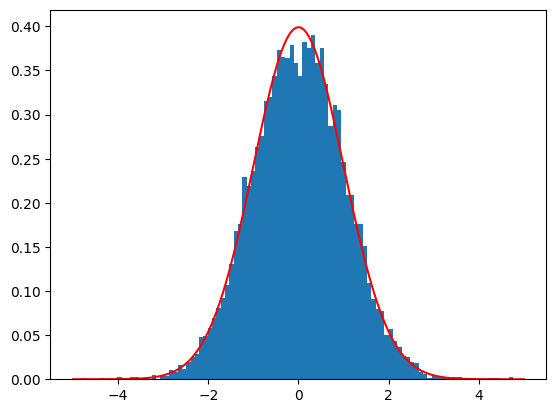

In [129]:
#Ziggurat
def ziggurat(n=10000):                                  
    results = np.empty(n)                 #zaimplementowany algorytm ziggurata
    pdf_count = 0                         #przyjmuje wielkość generowanej próbki i zwraca tablice z wygenerowanymi wartościami
    for i in range(n):
        control = True
        while control:
            u1 = np.random.uniform(-1,1)
            u2 = np.random.uniform()
            idx = np.random.randint(0, len(xs))
            if idx == 0:
                control = False
                results[i] = fallback()
            x = u1*xs[idx-1]
            if abs(x) < xs[idx]:
                control = False
            else:
                y = ys[idx] + u2*(ys[idx]-ys[idx-1])
                fx = exp(x)
                pdf_count += 1
                if y < fx:
                    control = False
        results[i] = x
    return results, pdf_count    
data, pdf_count = ziggurat()
x = np.linspace(-5,5,1000)
plt.hist(data, bins='sqrt', density=True)
plt.plot(x, stats.norm.pdf(x), c='r')

In [151]:
start = time.perf_counter()
data = ziggurat()
end = time.perf_counter()
ziggurat_time = end-start
ziggurat_pvalue_ks = scipy.stats.kstest(data[0], 'norm')[1]
ziggurat_pvalue_jb = scipy.stats.jarque_bera(data[0])[1]

Porównanie wyników poszczególnych metod:

In [152]:
print(f"Metoda odwrotnej dystrybuanty: Wydajność {inv_cdf_time:.5f}, pvalue test Kołmogorowa-Smirnowa {inv_cdf_pvalue_ks:.5f}, pvalue test Jarque-Bera {inv_cdf_pvalue_jb:.5f}")
print(f"Metoda akceptacji odrzucenia: Wydajność {accept_reject_time:.5f}, pvalue test Kołmogorowa-Smirnowa {accept_reject_pvalue_ks:.5f}, pvalue test Jarque-Bera {accept_reject_pvalue_jb:.5f}")
print(f"Metoda stosunku jednostajnych: Wydajność {ratio_time:.5f}, pvalue test Kołmogorowa-Smirnowa {ratio_pvalue_ks:.5f}, pvalue test Jarque-Bera {ratio_pvalue_jb:.5f}")
print(f"Metoda Boxa-Mullera: Wydajność {box_muller_time:.5f}, pvalue test Kołmogorowa-Smirnowa {box_muller_pvalue_ks:.5f}, pvalue test Jarque-Bera {box_muller_pvalue_jb:.5f}")
print(f"Metoda Marsaglii: Wydajność {marsaglia_time:.5f}, pvalue test Kołmogorowa-Smirnowa {marsaglia_pvalue_ks:.5f}, pvalue test Jarque-Bera {marsaglia_pvalue_jb:.5f}")
print(f"Metoda Zigguratu: Wydajność {ziggurat_time:.5f}, pvalue test Kołmogorowa-Smirnowa {ziggurat_pvalue_ks:.5f}, pvalue test Jarque-Bera {ziggurat_pvalue_jb}")

Metoda odwrotnej dystrybuanty: Wydajność 0.00239, pvalue test Kołmogorowa-Smirnowa 0.33066, pvalue test Jarque-Bera 0.37811
Metoda akceptacji odrzucenia: Wydajność 1.58763, pvalue test Kołmogorowa-Smirnowa 0.26449, pvalue test Jarque-Bera 0.27996
Metoda stosunku jednostajnych: Wydajność 0.19129, pvalue test Kołmogorowa-Smirnowa 0.48176, pvalue test Jarque-Bera 0.55292
Metoda Boxa-Mullera: Wydajność 0.00174, pvalue test Kołmogorowa-Smirnowa 0.42739, pvalue test Jarque-Bera 0.72672
Metoda Marsaglii: Wydajność 0.24570, pvalue test Kołmogorowa-Smirnowa 0.67407, pvalue test Jarque-Bera 0.76275
Metoda Zigguratu: Wydajność 0.18014, pvalue test Kołmogorowa-Smirnowa 0.19172, pvalue test Jarque-Bera 1.5045876038174896e-20


Każda z metod oprócz metodu Zigguratu dla testu Jarque-Bera zwraca pvalue wyższe niz 0.05 co oznacza że symulacje zwracają próbę z rozkładu $N(0,1)$

## Zadanie 5

Wektor zmiennych zależnych z rozkładu normalnego generujemy za pomocą macierzy kowariancji oraz rozkładu Choleskiego. Następnie sprawdzamy jak zależność wygenerowanych zmiennych wpływa na rozkłady $X+Y$, $X - Y$ oraz $X^2+Y^2$.

In [197]:
neg_strong = np.array([[ 1, -0.9],
                [ -0.9, 1 ]])
pos_strong = np.array([[ 1, 0.9],
                [ 0.9, 1 ]])
neg_weak = np.array([[ 1, -0.1],
                [ -0.1, 1 ]])
pos_weak = np.array([[ 1, 0.1],
                [ 0.1, 1 ]])
not_corr = np.array([[ 1, 0],
                [ 0, 1 ]])

def norm_vec(matrix, n):
    A = cholesky(matrix, lower=False)
    Z = np.random.normal(loc=0, scale=1, size=(n, 2))
    X = Z @ A
    return X[:,0], X[:,1]

In [198]:
x1, y1 = norm_vec(neg_strong, 10000)
x2, y2 = norm_vec(neg_weak, 10000)
x3, y3 = norm_vec(pos_strong, 10000)
x4, y4 = norm_vec(pos_weak, 10000)
x5, y5 = norm_vec(not_corr, 10000)

Na poniższym wykresie możemy zobaczyć rozkłady zmiennej $X+Y$. Jak widać mocna korelacja zmiennych znacznie wpływa na wyglądu rozkładu sumy zmiennych. Gdy zmienne nie są skorelowane ich suma dobrze oddaje rozkład $N(\mu_x + \mu_y, \sqrt{\sigma^2_x + \sigma^2_y}). Dobrze oddają to histogramy estymujące gęstości rozkładów $X+Y$ oraz $X-Y$ na poniższych wykresach.

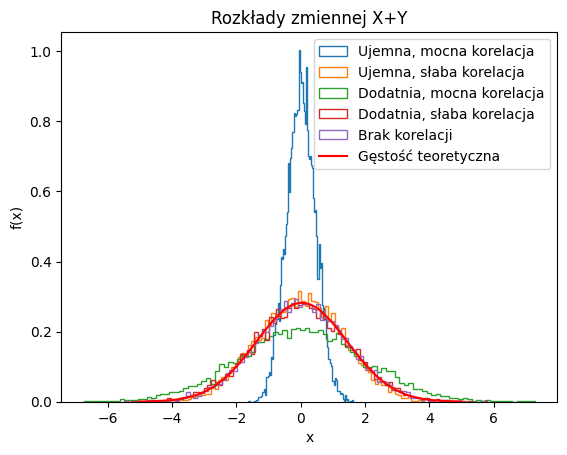

In [207]:
x_axis = np.linspace(-5,5, 100)
plt.hist(x1+y1, bins = 'sqrt', density=True, histtype='step', label='Ujemna, mocna korelacja')
plt.hist(x2+y2, bins = 'sqrt', density=True, histtype='step', label='Ujemna, słaba korelacja')
plt.hist(x3+y3, bins = 'sqrt', density=True, histtype='step', label='Dodatnia, mocna korelacja')
plt.hist(x4+y4, bins = 'sqrt', density=True, histtype='step', label='Dodatnia, słaba korelacja')
plt.hist(x5+y5, bins = 'sqrt', density=True, histtype='step', label='Brak korelacji')
plt.plot(x_axis, stats.norm.pdf(x_axis, loc = np.mean(x5)+np.mean(y5), scale = np.sqrt(2)), c='r', label='Gęstość teoretyczna')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.title('Rozkłady zmiennej X+Y')
plt.show()

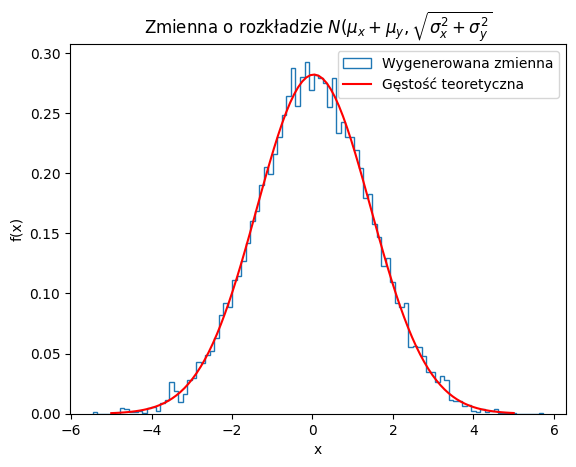

KstestResult(statistic=0.0087, pvalue=0.8435889342947497, statistic_location=1.3601678487986002, statistic_sign=-1)

In [202]:
plt.hist(x5+y5, bins = 'sqrt', density=True, histtype='step', label='Wygenerowana zmienna')
plt.plot(x_axis, stats.norm.pdf(x_axis, loc = np.mean(x5)+np.mean(y5), scale = np.sqrt(2)), c='r', label='Gęstość teoretyczna')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(r'Zmienna o rozkładzie $N(\mu_x + \mu_y, \sqrt{\sigma^2_x + \sigma^2_y}$')
plt.show()
scipy.stats.ks_2samp(x5+y5, stats.norm.rvs(size = 10000, loc = 0, scale = np.sqrt(2)))

Test statystyczny Kołmogorowa-Smirnowa także pozwala stwierdzić, że suma wygenerowanych nieskorelowanych zmiennych losowych dobrze oddaje rozkład $N(\mu_x + \mu_y, \sqrt{\sigma^2_x + \sigma^2_y})$.

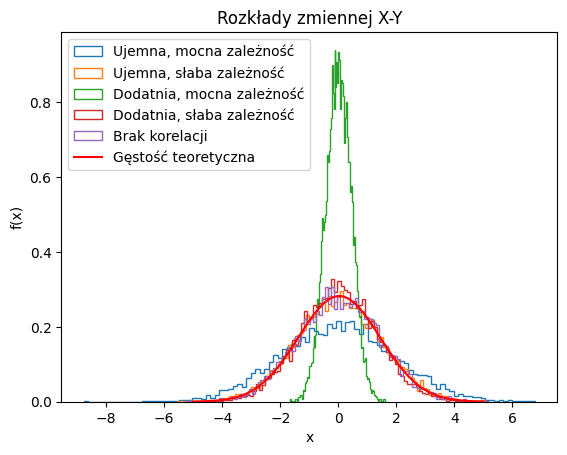

In [209]:
x_axis = np.linspace(-5,5, 100)
plt.hist(x1-y1, bins = 'sqrt', density=True, histtype='step', label='Ujemna, mocna zależność')
plt.hist(x2-y2, bins = 'sqrt', density=True, histtype='step', label='Ujemna, słaba zależność')
plt.hist(x3-y3, bins = 'sqrt', density=True, histtype='step', label='Dodatnia, mocna zależność')
plt.hist(x4-y4, bins = 'sqrt', density=True, histtype='step', label='Dodatnia, słaba zależność')
plt.hist(x5-y5, bins = 'sqrt', density=True, histtype='step', label='Brak korelacji')
plt.plot(x_axis, stats.norm.pdf(x_axis, loc = np.mean(x5)+np.mean(y5), scale = np.sqrt(2)), c='r', label='Gęstość teoretyczna')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.title('Rozkłady zmiennej X-Y')
plt.show()


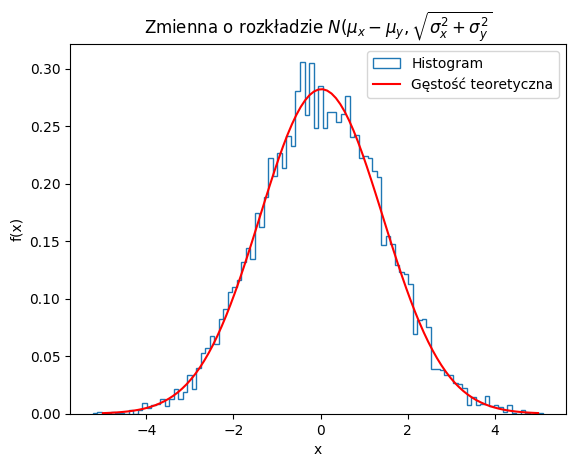

KstestResult(statistic=0.011, pvalue=0.5806415540561973, statistic_location=-0.13923820262477876, statistic_sign=1)

In [206]:
plt.hist(x5-y5, bins = 'sqrt', density=True, histtype='step', label='Histogram')
plt.plot(x_axis, stats.norm.pdf(x_axis, loc = np.mean(x5)-np.mean(y5), scale = np.sqrt(2)), c='r', label='Gęstość teoretyczna')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(r'Zmienna o rozkładzie $N(\mu_x - \mu_y, \sqrt{\sigma^2_x + \sigma^2_y}$')
plt.show()
scipy.stats.ks_2samp(x5-y5, stats.norm.rvs(size = 10000, loc = 0, scale = np.sqrt(2)))

Przy zmiennej losowej $X-Y$ test statystyczny oraz wykres histogramu oraz gęstości teoretycznej pozwala stwierdzić, że zwraca próba pochodzi z rozkładu $N(\mu_x - \mu_y, \sqrt{\sigma^2_x + \sigma^2_y})$

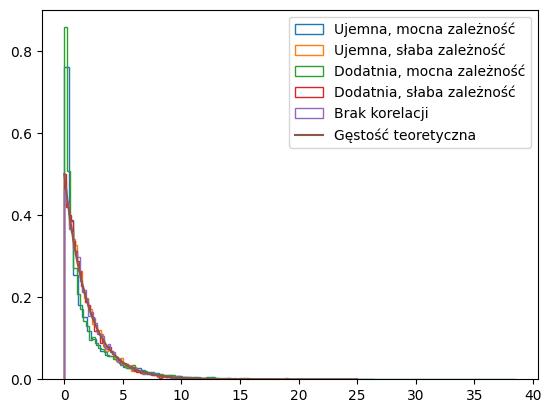

In [211]:
x_axis = np.linspace(0,25, 100)
plt.hist(x1**2+y1**2, bins = 'sqrt', density=True, histtype='step', label='Ujemna, mocna zależność')
plt.hist(x2**2+y2**2, bins = 'sqrt', density=True, histtype='step', label='Ujemna, słaba zależność')
plt.hist(x3**2+y3**2, bins = 'sqrt', density=True, histtype='step', label='Dodatnia, mocna zależność')
plt.hist(x4**2+y4**2, bins = 'sqrt', density=True, histtype='step', label='Dodatnia, słaba zależność')
plt.hist(x5**2+y5**2, bins = 'sqrt', density=True, histtype='step', label='Brak korelacji')
plt.plot(x_axis, stats.chi2.pdf(x_axis, 2), label='Gęstość teoretyczna')
plt.legend()
plt.show()


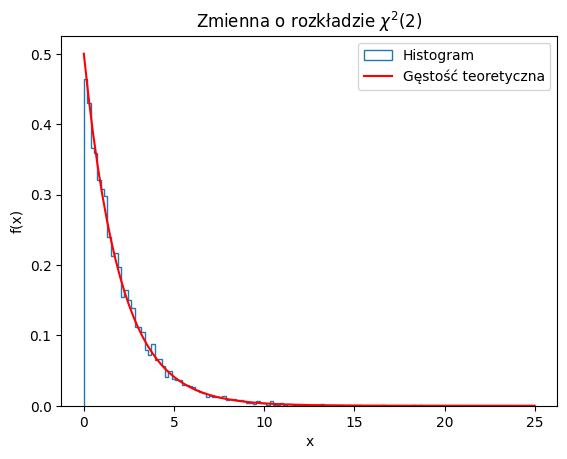

KstestResult(statistic=0.0212, pvalue=0.022340230544746754, statistic_location=0.9617034491104497, statistic_sign=-1)

In [214]:
plt.hist(x5**2+y5**2, bins = 'sqrt', density=True, histtype='step', label='Histogram')
plt.plot(x_axis, stats.chi2.pdf(x_axis, 2), label='Gęstość teoretyczna', c='r')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(r'Zmienna o rozkładzie $\chi^2(2)$')
plt.show()
scipy.stats.ks_2samp(x5**2+y5**2, stats.chi2.rvs(size = 10000, df=2))

W przypadku zmiennej $X^2 + Y^2$ próbka pochodzi z rozkładu chi kwadrat o dwóch stopniach swobody.